In [2]:
from u_net import *
from tools import *
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

In [3]:
image_dir= '../Dataset/images'
mask_dir = '../Dataset/masks'
img_size = (128, 128)

x_train, y_train = load_data(image_dir, mask_dir, img_size= img_size)
print(x_train.shape, y_train.shape)

(1454, 128, 128, 1) (1454, 128, 128, 1)


In [3]:
image_test_dir= '../Dataset/image - test'
mask_test_dir = '../Dataset/masks - test'
img_size = (128, 128)

x_test, y_test = load_data(image_test_dir, mask_test_dir, img_size= img_size)
print(x_test.shape, y_test.shape)

(300, 128, 128, 1) (300, 128, 128, 1)


In [4]:
data_gen_args = dict(
    #rotation_range=15,
    width_shift_range=0.12,
    height_shift_range=0.12,
    #shear_range=0.1,
    #zoom_range=0.1,
    #brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True
)

mask_data_gen_args = dict(
    #rotation_range=15,
    width_shift_range=0.12,
    height_shift_range=0.12,
    #shear_range=0.1,
    #zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip = True
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**mask_data_gen_args)

In [5]:
batch_size = 16

image_generator = image_datagen.flow(
    x_train.astype('float32'),
    batch_size=batch_size,
    seed=42,
    shuffle=False
)

mask_generator = mask_datagen.flow(
    y_train.astype('float32'),
    batch_size=batch_size,
    seed=42,
    shuffle=False
)

# Combine os geradores em um único gerador que fornece tuples de (imagem, máscara)
train_generator = zip(image_generator, mask_generator)
validation_data = (x_test, y_test)

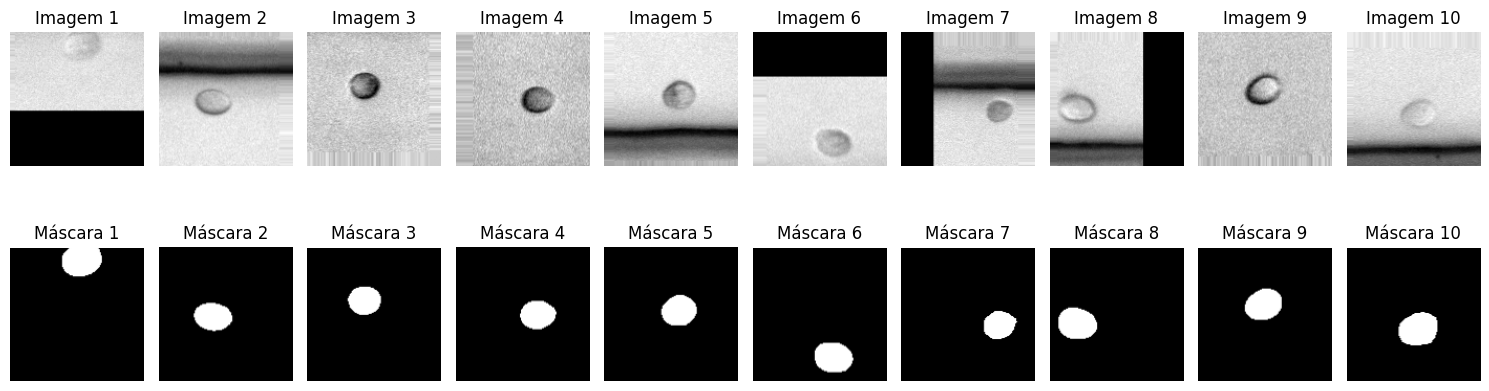

In [6]:
def plot_images_and_masks(images, masks, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Obter a próxima imagem e máscara transformada
        img_batch = next(image_generator)
        mask_batch = next(mask_generator)

        # Remover a dimensão do batch e do canal para visualização
        img = img_batch[0, :, :, 0]
        mask = mask_batch[0, :, :, 0]

        # Plotar a imagem
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Imagem {i + 1}")
        plt.axis('off')

        # Plotar a máscara
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Máscara {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plotar 5 amostras de imagens e máscaras transformadas
plot_images_and_masks(image_generator, mask_generator, num_samples=10)

In [ ]:
model = unet_reduzida()
model.compile(optimizer = Adam(learning_rate=1e-4), loss = dice_loss, metrics=[dice_coefficient])

In [8]:
early_stopping = EarlyStopping(
    monitor='val_dice_coefficient',
    patience = 10,
    mode='max',
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coefficient',
    factor=0.1,
    patience=10,
    min_lr=1e-6)

In [9]:
def generator():
    while True:
        img_batch = next(image_generator)
        mask_batch = next(mask_generator)
        mask_batch = np.where(mask_batch > 0.5, 1, 0).astype('float32')

        yield img_batch, mask_batch


train_generator = generator()

ii, mm = next(train_generator)
print(np.unique(mm[0, :, :, 0]))
print(np.shape(ii))

[0. 1.]
(16, 128, 128, 1)


In [10]:
steps_per_epoch = len(x_train) // batch_size
history = model.fit(
          train_generator,
          steps_per_epoch=steps_per_epoch,
          validation_data= validation_data,
          epochs= 200,
          callbacks=[early_stopping]
          )

Epoch 1/200
90/90 [==============================] - 52s 373ms/step - loss: 0.7824 - dice_coefficient: 0.2179 - val_loss: 0.9254 - val_dice_coefficient: 0.0740
Epoch 2/200
90/90 [==============================] - 19s 210ms/step - loss: 0.6564 - dice_coefficient: 0.3439 - val_loss: 0.5585 - val_dice_coefficient: 0.4302
Epoch 3/200
90/90 [==============================] - 19s 210ms/step - loss: 0.5695 - dice_coefficient: 0.4309 - val_loss: 0.4810 - val_dice_coefficient: 0.4941
Epoch 4/200
90/90 [==============================] - 19s 210ms/step - loss: 0.4980 - dice_coefficient: 0.5024 - val_loss: 0.2372 - val_dice_coefficient: 0.7659
Epoch 5/200
90/90 [==============================] - 19s 210ms/step - loss: 0.4373 - dice_coefficient: 0.5630 - val_loss: 0.1769 - val_dice_coefficient: 0.8189
Epoch 6/200
90/90 [==============================] - 19s 210ms/step - loss: 0.3750 - dice_coefficient: 0.6253 - val_loss: 0.1144 - val_dice_coefficient: 0.8847
Epoch 7/200
90/90 [=====================

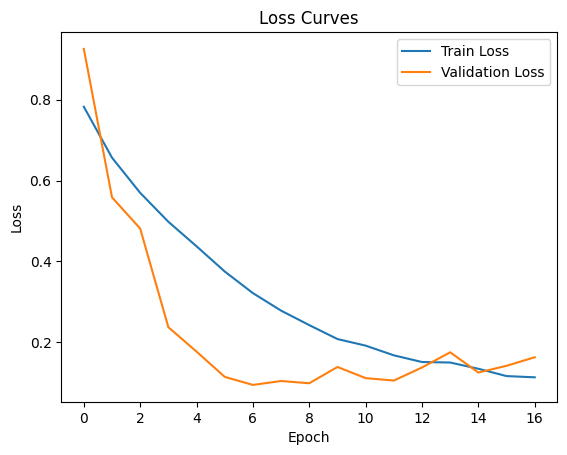

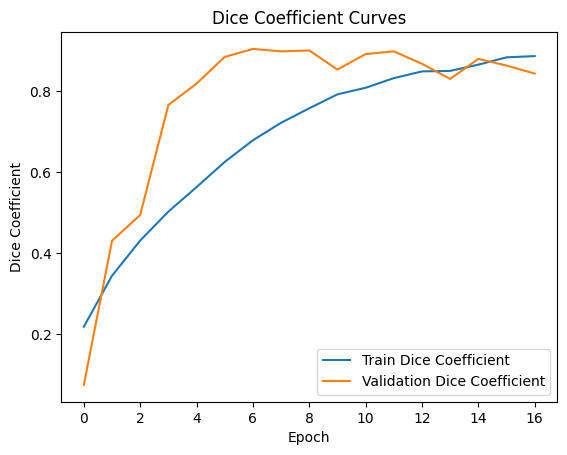

In [11]:
# Plotar a perda de treinamento e validação
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotar a métrica de treinamento e validação (ex: dice_coefficient)
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient Curves')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

10/10 [==============================] - 1s 108ms/step


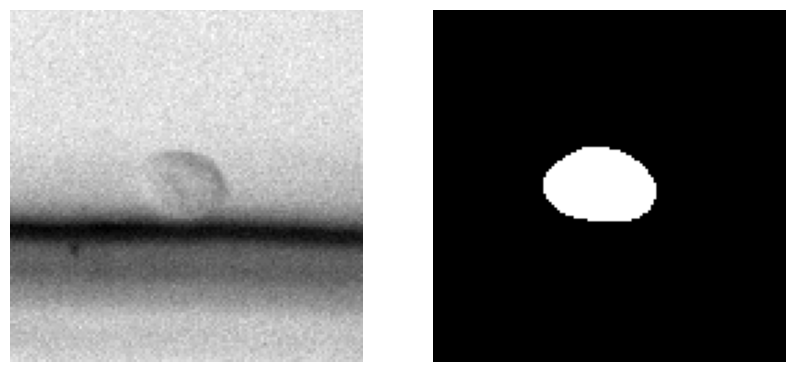

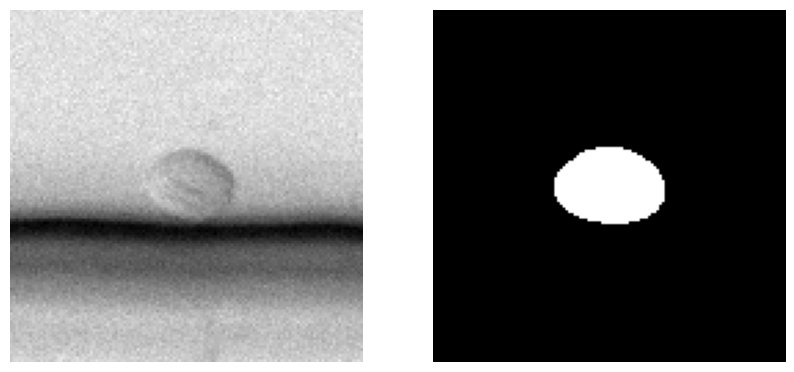

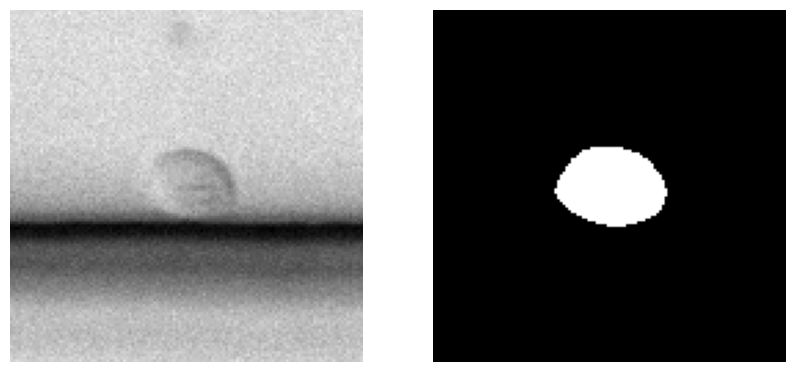

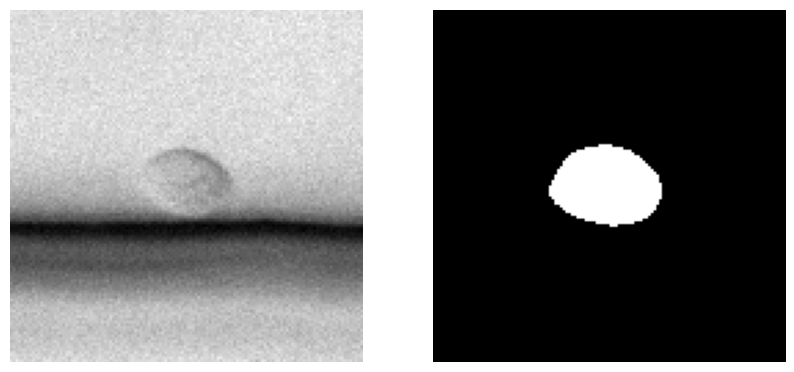

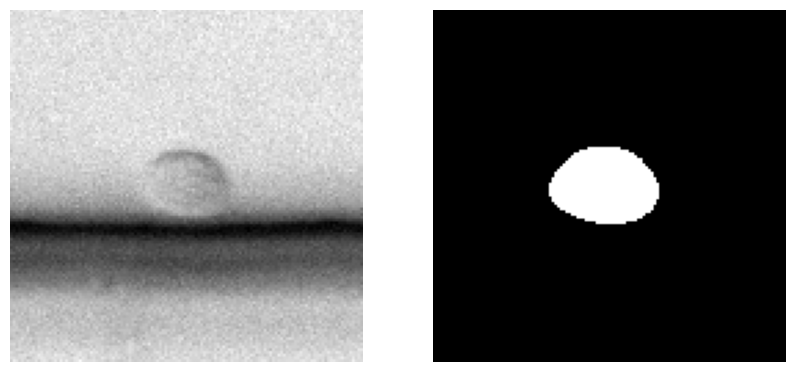

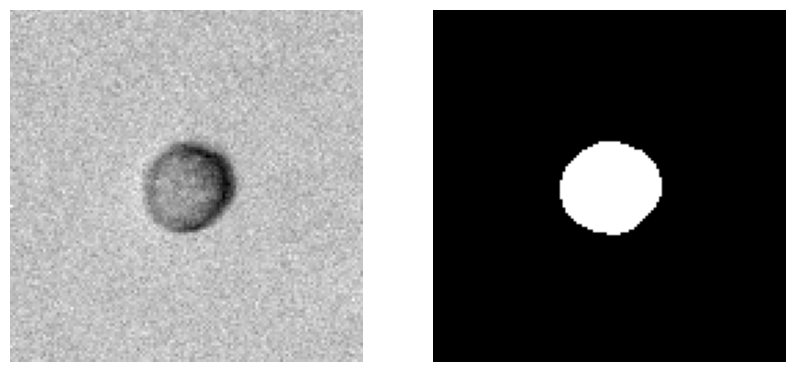

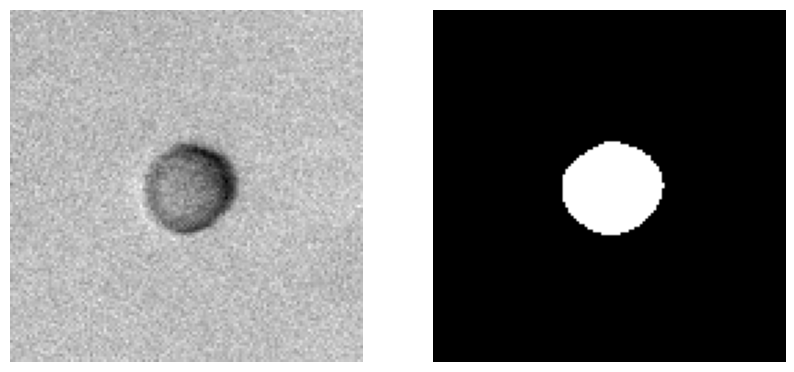

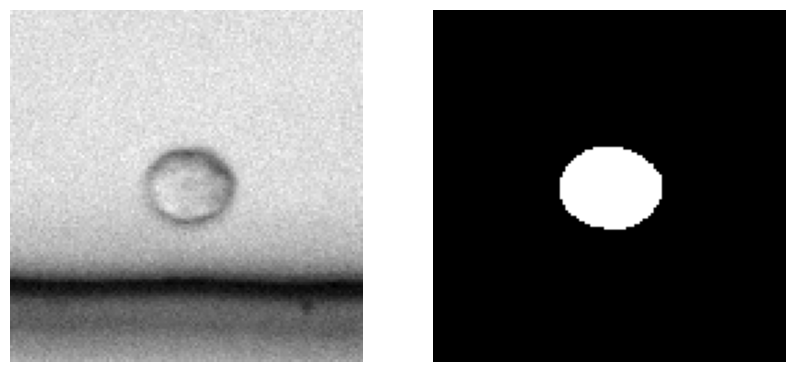

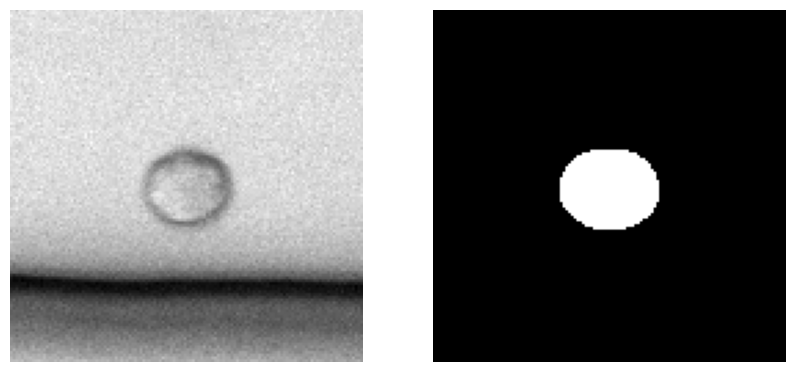

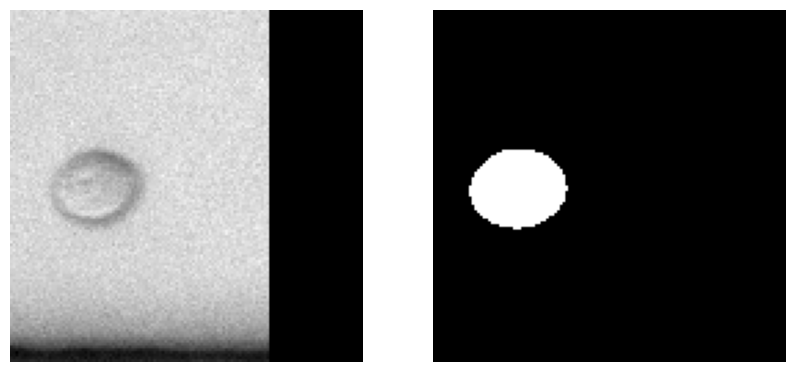

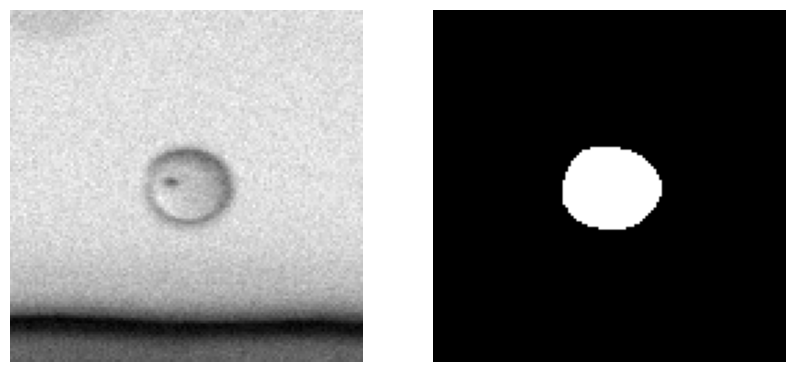

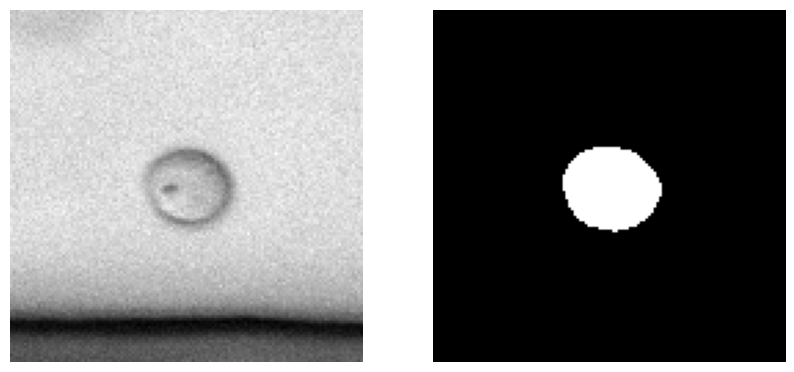

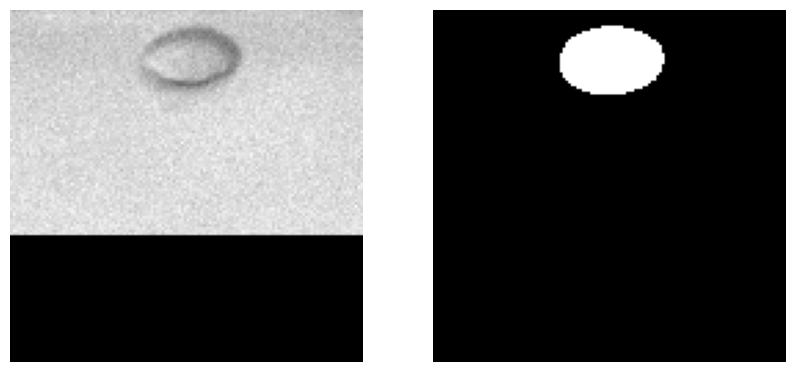

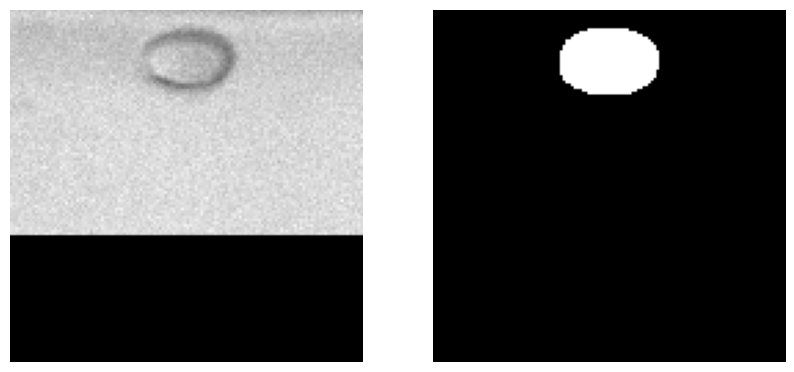

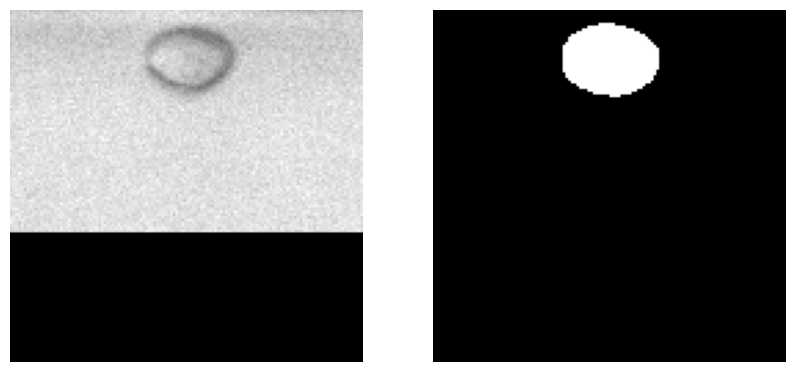

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Gerar previsões (máscaras)
predictions = model.predict(x_test)

# Exibir algumas imagens e suas máscaras binárias de segmentação
num_images = 15  # Número de imagens para mostrar
threshold = 0.7  # Limite para binarizar a máscara

for i in range(num_images):
    plt.figure(figsize=(10, 5))

    # Imagem original
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[i].reshape(x_test.shape[1], x_test.shape[2]), cmap='gray')
    plt.axis('off')

    # Máscara binária predita (aplicando limiar)
    binary_mask = (predictions[i] > threshold).astype(np.uint8)
    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask.reshape(x_test.shape[1], x_test.shape[2]), cmap='gray')
    plt.axis('off')

    plt.show()


In [15]:
model.save(
   "model_seg_128x128-0.90",
   save_format="tf"
)

INFO:tensorflow:Assets written to: model_seg_128x128-0.90\assets


INFO:tensorflow:Assets written to: model_seg_128x128-0.90\assets
